# NHANES and SHAP Tutorial

## Import Packages

In [1]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

## Import Data

In [2]:
X,y = shap.datasets.nhanesi() 
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

## Process Data for XGBoost

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

xgb_full = xgboost.DMatrix(X, label=y)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [4]:
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}

In [5]:
model_train = xgboost.train(
    params, 
    xgb_train, 
    10000, 
    evals = [(xgb_test, "test")], 
    verbose_eval=1000
)

[0]	test-cox-nloglik:7.26934
[1000]	test-cox-nloglik:6.55590
[2000]	test-cox-nloglik:6.48689
[3000]	test-cox-nloglik:6.47252
[4000]	test-cox-nloglik:6.47041
[5000]	test-cox-nloglik:6.47195
[6000]	test-cox-nloglik:6.47452
[7000]	test-cox-nloglik:6.47667
[8000]	test-cox-nloglik:6.47970
[9000]	test-cox-nloglik:6.48297
[9999]	test-cox-nloglik:6.48639


In [9]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(
    params, 
    xgb_full, 
    5000, 
    evals = [(xgb_full, "test")], 
    verbose_eval=1000
)

[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.16729
[2000]	test-cox-nloglik:8.07807
[3000]	test-cox-nloglik:8.03904
[4000]	test-cox-nloglik:8.01410
[4999]	test-cox-nloglik:7.99292


In [10]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8356161308582694

In [11]:
shap_values = shap.TreeExplainer(model).shap_values(X)

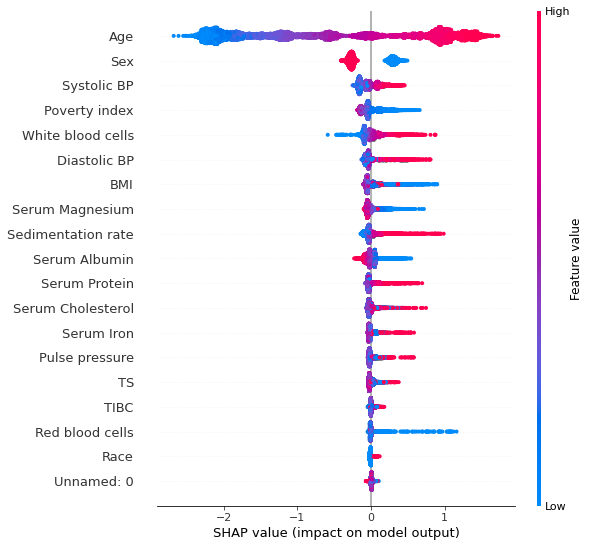

In [12]:
shap.summary_plot(shap_values, X)